# REINFORCE: Monte-Carlo Policy-Gradient Control (episodic)
From Chapter 13, Policy Gradient Methods (Sutton and Barto, 2018) **[1]**

## Import Packages

In [2]:
import gymnasium as gym
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## CartPole Problem

In [3]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print("_____Observation Space______")
print("State space size: ", state_size)
print("Sample observation: ", env.observation_space.sample())

print("_____Action Space______")
print("Action space size: ", action_size)
print("Sample action: ", env.action_space.sample())

_____Observation Space______
State space size:  4
Sample observation:  [-3.8416345e+00  1.5039845e+37  1.0098585e-01 -1.0112409e+38]
_____Action Space______
Action space size:  2
Sample action:  0


### Define an Agent (Parametrized Policy)
The policy must be differentiable. Here we define a linear policy.

In [4]:
class LinearPolicyAgent():
    def __init__(self, state_size, action_size, alpha=0.0001, gamma=1):
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor

        self.reset()

    def reset(self):
        self.weights = torch.rand((action_size, state_size), device=device)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        probabilities = torch.matmul(self.weights, state.T) # compute action preferences eq 13.3
        policy = torch.functional.F.softmax(probabilities, dim=0).T # softmax in action preferences eq 13.2

        action_idx = torch.multinomial(policy, 1).item() # sample action from policy

        return action_idx
    
    def update_policy(self, weights):
        self.weights = weights

# test the policy
debug_policy = LinearPolicyAgent(state_size, action_size)
debug_policy.act(env.reset()[0])

0

### Define the Learning Algorithm

In [5]:
def reinforce(environment, agent, n_episodes, max_steps):
    total_rewards = np.zeros(n_episodes)

    for i in range(n_episodes):
        rewards_history = []
        action_history = []
        state_history = []

        state = env.reset()[0]

        # Generate an episode S0, A0, R1, ..., ST-1, AT-1, RT, following pi(.|., theta)
        for j in range(max_steps):

            action_idx = agent.act(state)

            next_state, reward, done, _, _ = env.step(action_idx)

            action_history.append(action_idx)
            state_history.append(state)
            rewards_history.append(reward)

            state = next_state

            if done:
                break

        total_rewards[i] = sum(rewards_history)

        # Update policy parameters, eq. 13.8
        for t in range(len(state_history))[::-1]: # exclude the goal state from the update
            state = torch.from_numpy(state_history[t]).float().unsqueeze(0).to(device)
            action_idx = action_history[t]

            # compute the return following time t
            gt = agent.gamma ** np.arange(len(rewards_history[t:])) * np.array(rewards_history[t:])
            gt = agent.gamma ** t * np.sum(gt)

            # compute the gradient of the log policy
            probabilities = torch.matmul(agent.weights, state.T) # compute action preferences eq 13.3
            policy = torch.functional.F.softmax(probabilities, dim=0) # softmax in action preferences eq 13.2
            current_features = state[:, action_idx]
            grad_log_pi = current_features - torch.dot(policy[action_idx], current_features)

            # update the policy parameters
            agent.update_policy(agent.weights + agent.alpha * agent.gamma ** t * gt * grad_log_pi)

    return total_rewards

### Train

In [6]:
linear_policy_agent = LinearPolicyAgent(state_size, action_size, alpha=0.01, gamma=1)
scores = reinforce(env, linear_policy_agent, n_episodes=1000, max_steps=1000)

print(f"Maximum score over 1000 episodes: {np.max(scores)}")

Maximum score over 1000 episodes: 110.0


### Define an ANN Policy Agent
In this occurence we will use an MLP to as parametrized policy which should work since it is differenciable.

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return torch.functional.F.softmax(x, dim=1)


class MLPPolicyAgent(torch.nn.Module):
    def __init__(self, state_size, action_size, hidden_size, alpha=0.0001, gamma=1):
        super().__init__()
        
        self.alpha = alpha
        self.gamma = gamma

        self.policy = MLP(state_size, action_size, hidden_size=hidden_size).to(device)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probabilities = self.policy(state)
        action_idx = torch.multinomial(probabilities, 1).item()
        return action_idx
    
    def update_policy(self, weights):
        self.policy.load_state_dict(weights)

Here we will also reimplement the REINFORCE learning algorithm using Pytorch graph computing for optimization.

In [8]:
def reinforce_pytorch(environment, agent, optimizer, n_episodes, max_steps):
    total_rewards = np.zeros(n_episodes)

    for i in range(n_episodes):
        rewards_history = []
        action_history = []
        state_history = []

        state = env.reset()[0]

        # Generate an episode S0, A0, R1, ..., ST-1, AT-1, RT, following pi(.|., theta)
        for j in range(max_steps):

            action_idx = agent.act(state)

            next_state, reward, done, _, _ = env.step(action_idx)

            action_history.append(action_idx)
            state_history.append(state)
            rewards_history.append(reward)

            state = next_state

            if done:
                break

        total_rewards[i] = sum(rewards_history)

        # Update policy parameters, eq. 13.8
        for t in range(len(state_history))[::-1]: # exclude the goal state from the update
            state = torch.from_numpy(state_history[t]).float().unsqueeze(0).to(device)
            action_idx = action_history[t]

            # compute the return following time t
            gt = agent.gamma ** np.arange(len(rewards_history[t:])) * np.array(rewards_history[t:])
            gt = agent.gamma ** t * np.sum(gt)

        # Here we do things a bit differently in order to leverage PyTorch's optimizers
        # First, we compute the loss
        # compute the gradient of the log policy
        probabilities = agent.policy(state)
        current_features = state[:, action_idx]
        grad_log_pi = current_features - torch.dot(probabilities[:, action_idx], current_features)
        loss = -gt * grad_log_pi

        # Then we compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # Finally, we update the policy parameters
        optimizer.step()


    return total_rewards

In [9]:
mlp_policy_agent = MLPPolicyAgent(state_size, action_size, hidden_size=16, alpha=0.01, gamma=1).to(device)

optimizer = torch.optim.Adam(mlp_policy_agent.parameters(), lr=0.01)

scores = reinforce_pytorch(env, mlp_policy_agent, optimizer=optimizer, n_episodes=1000, max_steps=1000)

print(f"Maximum score over 1000 episodes: {np.max(scores)}")

Maximum score over 1000 episodes: 84.0


## Visualization

In [10]:
n_runs = 1
n_episodes = 1000
# alphas = [2**-12, 2**-13, 2**-14]
alphas = [2**-1, 2**-2, 2**-3]

avg_per_episode = np.zeros((len(alphas), n_runs, n_episodes))

for i, alpha in enumerate(alphas):
    for j in range(n_runs):
        message = f"Run {j+1}/{n_runs} out of alpha={i}/{len(alphas)}"
        print(message, end="\r")

        # agent = LinearPolicyAgent(state_size, action_size, alpha=alpha, gamma=1)
        # scores = reinforce(env, agent, n_episodes=n_episodes, max_steps=1000)
        agent = MLPPolicyAgent(state_size, action_size, hidden_size=16, alpha=alpha, gamma=1).to(device)
        scores = reinforce_pytorch(env, agent, optimizer=optimizer, n_episodes=n_episodes, max_steps=1000)

        avg_per_episode[i, j, :] = scores

avg_per_episode = np.mean(avg_per_episode, axis=1)

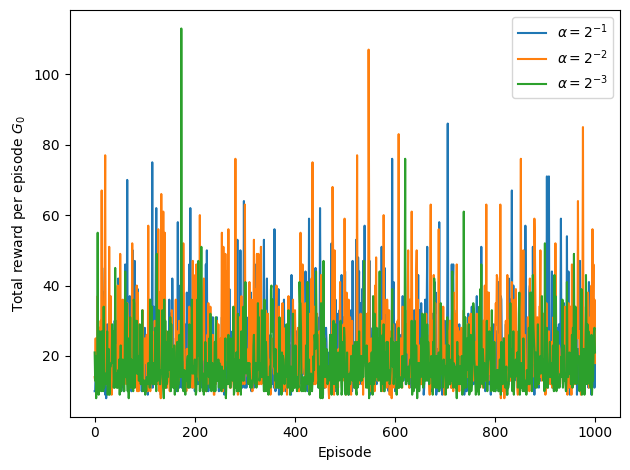

In [11]:
import matplotlib.pyplot as plt

for i, alpha in enumerate(alphas):
    plt.plot(np.arange(n_episodes), avg_per_episode[i], label=r'$\alpha=2^{{{:.0f}}}$'.format(np.log2(alpha)))

plt.xlabel('Episode')
plt.ylabel(r'Total reward per episode $G_{0}$')

plt.legend()
plt.tight_layout()

plt.show()

### HuggingFace Cartpole Implementation
https://huggingface.co/learn/deep-rl-course/unit4/hands-on

In [12]:
class Policy(torch.nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = torch.nn.Linear(s_size, h_size)
        self.fc2 = torch.nn.Linear(h_size, a_size)

    def forward(self, x):
        x = torch.functional.F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.functional.F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [17]:
from collections import deque

def reinforce_hf(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep,
        # as
        #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...

        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))

    return scores

In [18]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": "CartPole-v1",
    "state_space": state_size,
    "action_space": action_size,
}

# Create policy and place it to the device
cartpole_policy = Policy(
    cartpole_hyperparameters["state_space"],
    cartpole_hyperparameters["action_space"],
    cartpole_hyperparameters["h_size"],
).to(device)
cartpole_optimizer = torch.optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

scores = reinforce_hf(
    cartpole_policy,
    cartpole_optimizer,
    cartpole_hyperparameters["n_training_episodes"],
    cartpole_hyperparameters["max_t"],
    cartpole_hyperparameters["gamma"],
    100,
)

Episode 100	Average Score: 33.13
Episode 200	Average Score: 130.89
Episode 300	Average Score: 432.55
Episode 400	Average Score: 568.22
Episode 500	Average Score: 738.49
Episode 600	Average Score: 958.96
Episode 700	Average Score: 941.77
Episode 800	Average Score: 1000.00
Episode 900	Average Score: 1000.00
Episode 1000	Average Score: 1000.00


In [21]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param policy: The Reinforce agent
    """
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()[0]
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info, _ = env.step(action)
            total_rewards_ep += reward

            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [22]:
eval_env = gym.make(cartpole_hyperparameters["env_id"])

evaluate_agent(
    eval_env, cartpole_hyperparameters["max_t"], cartpole_hyperparameters["n_evaluation_episodes"], cartpole_policy
)

(1000.0, 0.0)

## References

- **[1]** R. S. Sutton and A. G. Barto, Reinforcement learning: an introduction, Second edition. in Adaptive computation and machine learning series. Cambridge, Massachusetts: The MIT Press, 2018.